In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import time
import os
import copy

from collections import defaultdict
import random
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm 
import glob

# cudnn.benchmark = True

In [2]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5, figsize=(12, 6)):
    rows = int(np.ceil(len(images_filepaths) / cols))
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color, size=20)
        ax.ravel()[i].set_axis_off()
    for i in range(rows * cols - len(images_filepaths)):
        ax.ravel()[(-1*(rows * cols - len(images_filepaths) - i))].set_axis_off()
    plt.tight_layout()
    plt.show()
    
class ConvRetDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "retina":
            label = 1
        else:
            label = 0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label
    
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [3]:
params = {
    "model": "densenet121",
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "lr": 0.001,
    "batch_size": 4,
    "num_workers": 0,
    "epochs": 10,
}

In [4]:
root_directory = os.path.join("data", "data_m")

images_filepaths={
"train" : glob.glob(os.path.join(root_directory, "train", "*", "*")),
"val"   : glob.glob(os.path.join(root_directory, "val", "*", "*")),
"test"  : glob.glob(os.path.join(root_directory, "test", "*", "*"))
}


data_transforms = {
    'train': A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}

datasets = {x: ConvRetDataset(images_filepaths=images_filepaths[x], transform=data_transforms[x]) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True) for x in ['train', 'val', 'test']}

In [5]:
x, d = next(iter(dataloaders['test']))

In [6]:
x, d = next(iter(dataloaders['test']))

In [7]:
import torchvision
class Transforms:
    def __init__(self):
        self.transforms = data_transforms['test']

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']
    
data_dir = 'data/data_m'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), Transforms()) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

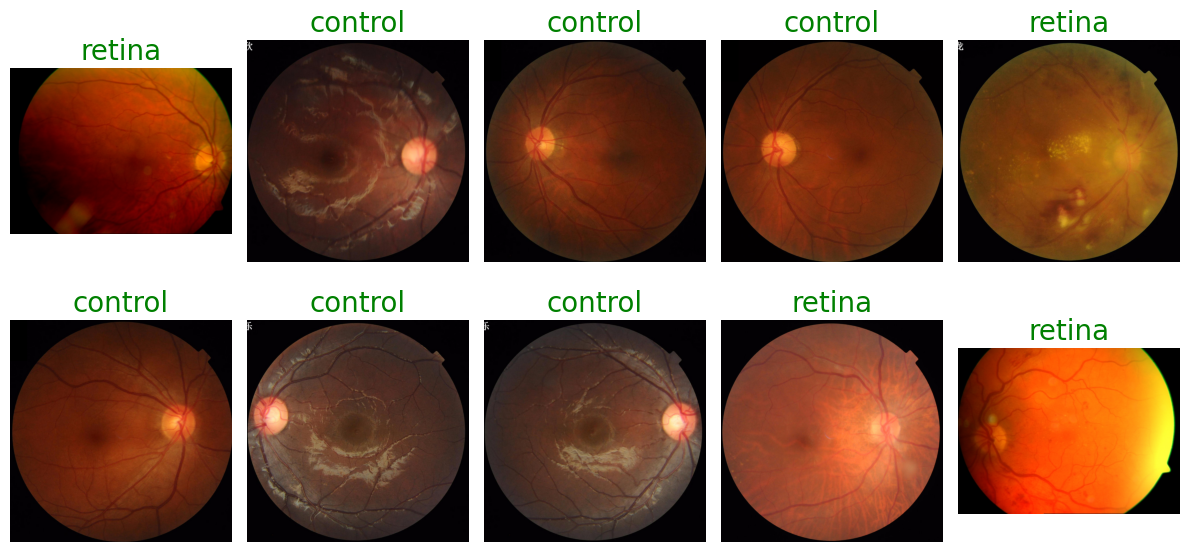

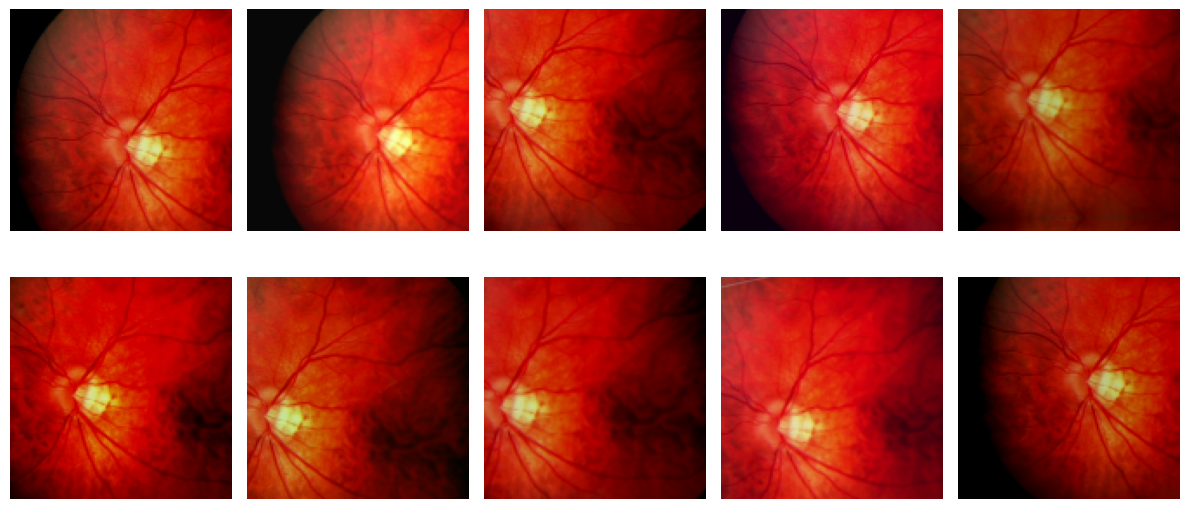

In [8]:
display_image_grid(random.sample(images_filepaths["train"],10))

visualize_augmentations(datasets["train"])

In [9]:
model = getattr(models, params["model"])(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
model = model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=params["epochs"]):
    since = time.time()
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(params["device"])
                labels = labels.to(params["device"])
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred = torch.argmax(outputs, dim=1)
                correct = pred.eq(labels)
                running_corrects += torch.sum(correct.float())
                torch.cuda.empty_cache() 
            epoch_loss = running_loss  / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
                scheduler.step()
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc.item())
            else:
                valid_loss_list.append(epoch_loss)
                valid_acc_list.append(epoch_acc.item())                           
            plint = phase if phase == 'train' else 'valid'
            print(f'{plint} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    xepoch = np.arange(num_epochs, dtype=int)+1

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, layout="constrained")

    ax1.plot(xepoch, train_loss_list, label='train')
    ax1.plot(xepoch, valid_loss_list, label='valid')
    ax1.legend(loc="center right")
    ax1.set_ylabel('loss')

    ax2.plot(xepoch, train_acc_list, label='train')
    ax2.plot(xepoch, valid_acc_list, label='valid')
    ax2.legend(loc="center right")
    ax2.set_ylabel('accuracy')
    plt.plot()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def test_model(model):
    was_training = model.training
    model.eval()
    predicted_labels = []
    test_acc = 0
    for i, data in enumerate(dataloaders['test'], 0):
        samples, labels = data
        with torch.no_grad():            
            samples, labels = samples.to(params["device"]), labels.to(params["device"])
            output = model(samples)
            loss = criterion(output, labels)
            pred = torch.argmax(output, dim=1)
            predicted_labels += ["retina" if is_cat else "control" for is_cat in pred]
            correct = pred.eq(labels)
            test_acc += torch.sum(correct.float())
            torch.cuda.empty_cache()
            model.train(mode=was_training)
    print('Testing Accuracy: {:.2f} %'.format(100*test_acc/dataset_sizes['test']))
    display_image_grid(images_filepaths["test"], predicted_labels, figsize=(20, 20))

Epoch [1/15]
train Loss: 0.6356 Acc: 0.6710
valid Loss: 0.6678 Acc: 0.6881
Epoch [2/15]
train Loss: 0.4081 Acc: 0.8120
valid Loss: 0.2585 Acc: 0.8899
Epoch [3/15]
train Loss: 0.2616 Acc: 0.8851
valid Loss: 0.1829 Acc: 0.9174
Epoch [4/15]
train Loss: 0.2423 Acc: 0.9191
valid Loss: 0.3296 Acc: 0.8716
Epoch [5/15]
train Loss: 0.2508 Acc: 0.8930
valid Loss: 0.2748 Acc: 0.8716
Epoch [6/15]
train Loss: 0.2851 Acc: 0.8851
valid Loss: 0.2527 Acc: 0.9083
Epoch [7/15]
train Loss: 0.2004 Acc: 0.9086
valid Loss: 0.2256 Acc: 0.8991
Epoch [8/15]
train Loss: 0.2272 Acc: 0.9008
valid Loss: 0.2178 Acc: 0.9083
Epoch [9/15]
train Loss: 0.2020 Acc: 0.9112
valid Loss: 0.2066 Acc: 0.8991
Epoch [10/15]
train Loss: 0.1971 Acc: 0.9034
valid Loss: 0.1893 Acc: 0.9266
Epoch [11/15]
train Loss: 0.1566 Acc: 0.9426
valid Loss: 0.1827 Acc: 0.9266
Epoch [12/15]
train Loss: 0.1833 Acc: 0.9112
valid Loss: 0.2253 Acc: 0.8899
Epoch [13/15]
train Loss: 0.1495 Acc: 0.9399
valid Loss: 0.1797 Acc: 0.9358
Epoch [14/15]
train L

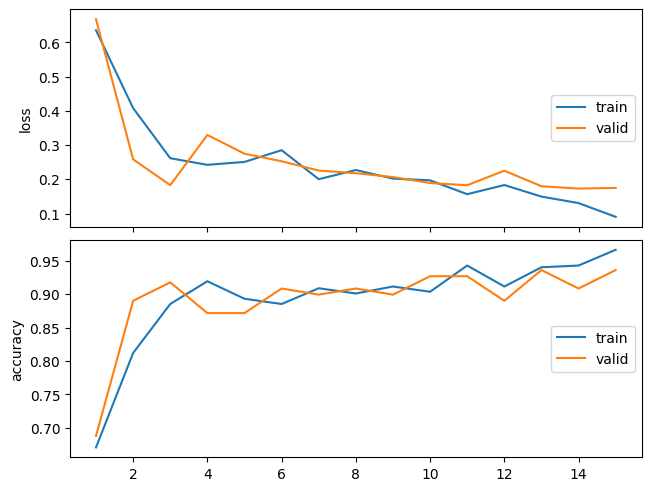

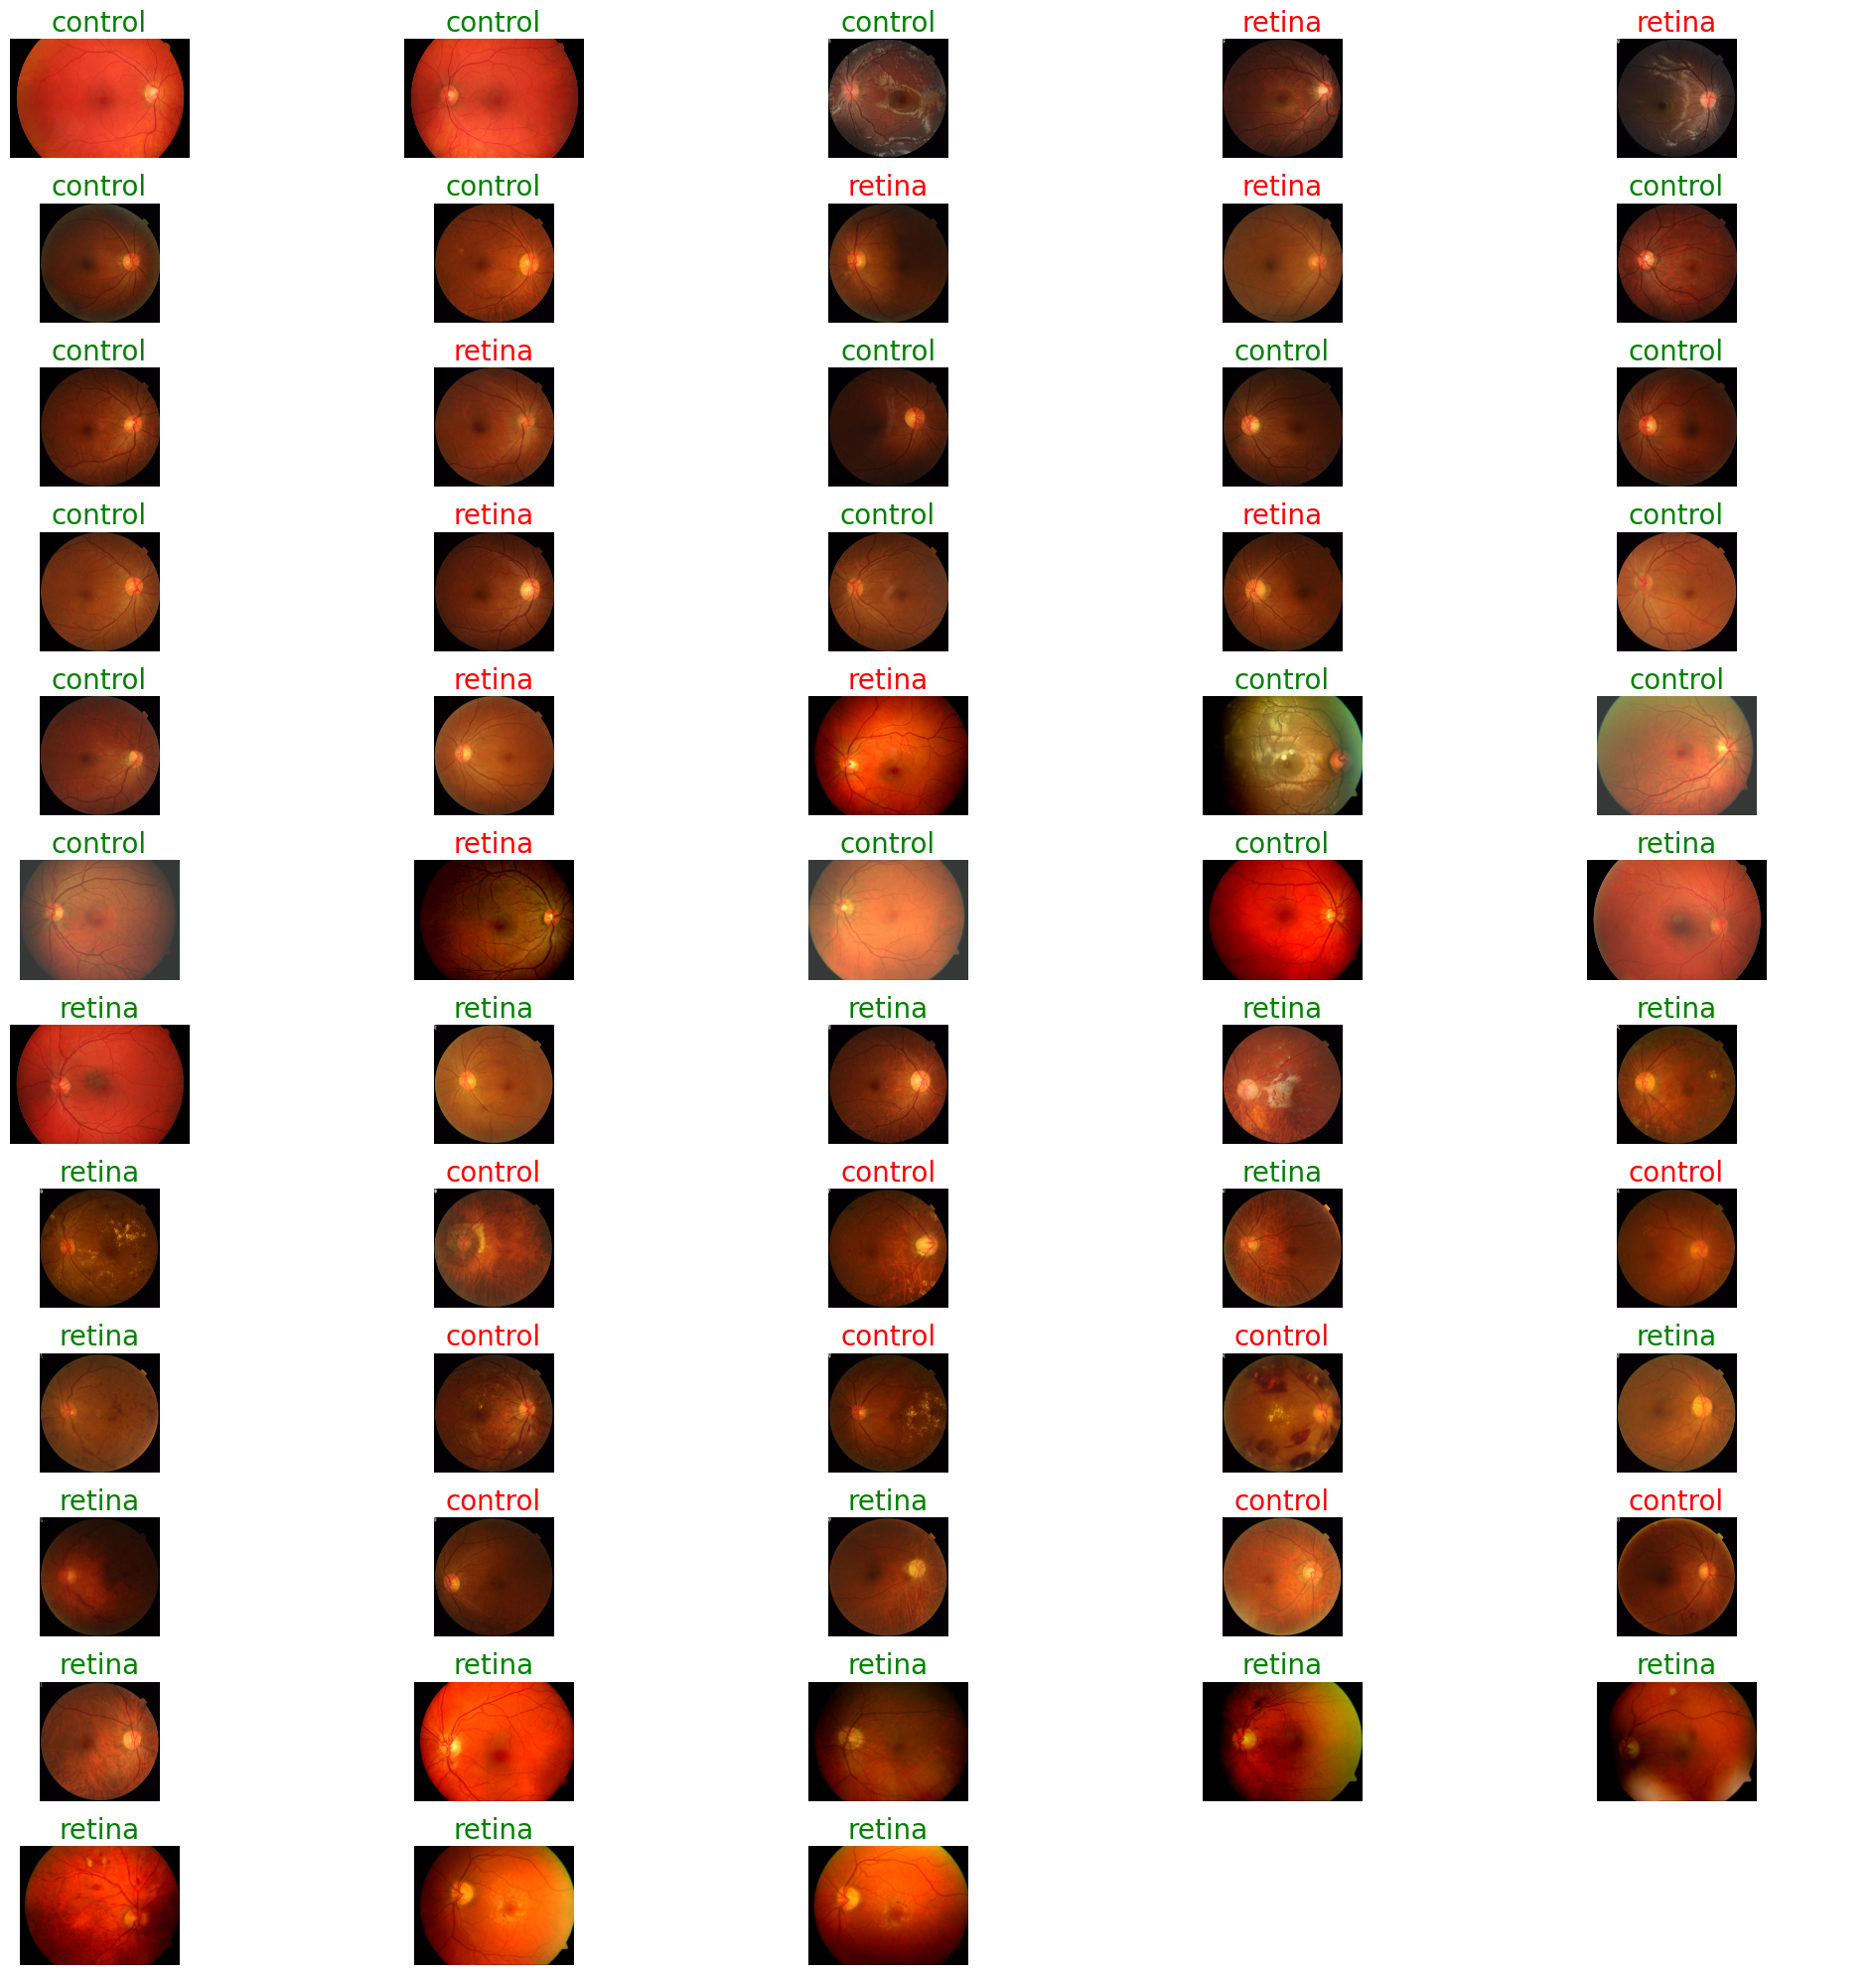

In [12]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=50 )
test_model(model)
torch.cuda.empty_cache()